In [54]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import os
os.chdir('/home/kt/calc/latticeG')

In [56]:
import torch
import time
import scipy.io as sio
from hamiltonians.Central import SSH2DChainMethod
from hamiltonians.Lead import SpinlessLead
from genfunc_cf_deriv_method.calculations.calculation_cf_autograd import calculation_cf_autograd
from greens_functions_inv_method.transport_calculation import calculate_transport_properties
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

# Define device for computations
funcDevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {funcDevice}")

# --- 1. Define SSH Model Parameters ---
Nx_cell, Ny_cell = 10, 10  # Number of unit cells in x and y directions
Nx, Ny = Nx_cell * 2, Ny_cell * 2  # Total number of sites (2 sites per unit cell in each direction)
orb_size = 1  # Orbital size for 2D SSH model

# Define SSH parameters (using complex tensors for consistency)
gamma_x = torch.tensor(8, dtype=torch.complex64, device=funcDevice)  # Intra-cell hopping along x
gamma_y = torch.tensor(8, dtype=torch.complex64, device=funcDevice)  # Intra-cell hopping along y
lambda_x = torch.tensor(10.0, dtype=torch.complex64, device=funcDevice)  # Inter-cell hopping along x
lambda_y = torch.tensor(10.0, dtype=torch.complex64, device=funcDevice)  # Inter-cell hopping along y

# Print model parameters for verification
print(f"System size: {Nx_cell}×{Ny_cell} unit cells ({Nx}×{Ny} sites)")
print(f"Model parameters: γx={gamma_x}, γy={gamma_y}, λx={lambda_x}, λy={lambda_y}")

Using device: cpu
System size: 10×10 unit cells (20×20 sites)
Model parameters: γx=(8+0j), γy=(8+0j), λx=(10+0j), λy=(10+0j)


In [57]:
# --- 2. Create SSH Hamiltonian using Chain Method ---
print("Constructing 2D SSH Hamiltonian...")
ssh2d_model = SSH2DChainMethod(Nx_cell, Ny_cell, gamma_x, gamma_y, lambda_x, lambda_y)


Constructing 2D SSH Hamiltonian...


States within the gap (±1): [-0.56731665 -0.56731343  0.5673125   0.56731427]

Wavefunction values at corners for gap states:
State 1 (Energy: -0.5673):
  Corner 0: 0.0000 + 0.0000j
  Corner 380: -0.1906 + 0.0000j
  Corner 19: -0.1906 + 0.0000j
  Corner 399: -0.2695 + 0.0000j
State 2 (Energy: -0.5673):
  Corner 0: 0.2695 + 0.0000j
  Corner 380: 0.1906 + 0.0000j
  Corner 19: -0.1906 + 0.0000j
  Corner 399: 0.0000 + 0.0000j
State 3 (Energy: 0.5673):
  Corner 0: -0.0000 + 0.0000j
  Corner 380: -0.1906 + 0.0000j
  Corner 19: -0.1906 + 0.0000j
  Corner 399: 0.2695 + 0.0000j
State 4 (Energy: 0.5673):
  Corner 0: 0.2695 + 0.0000j
  Corner 380: -0.1906 + 0.0000j
  Corner 19: 0.1906 + 0.0000j
  Corner 399: 0.0000 + 0.0000j


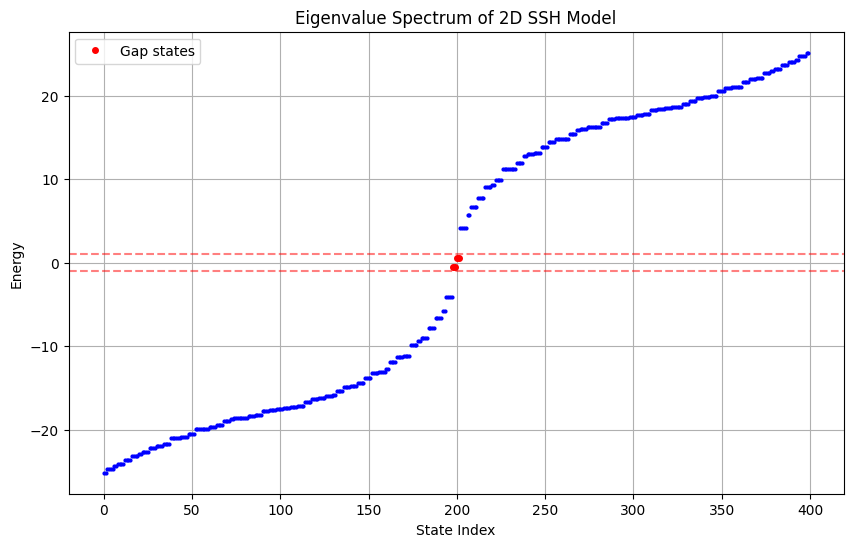

In [58]:
# Calculate eigenvalues and eigenvectors of the SSH Hamiltonian
eigenvalues, eigenvectors = torch.linalg.eigh(ssh2d_model.H_full)

# Convert to numpy for plotting and analysis
eigenvalues_np = eigenvalues.cpu().numpy()
eigenvectors_np = eigenvectors.cpu().numpy()

# Define gap threshold
gap = 1

# Find states within the gap
gap_indices = np.where((eigenvalues_np > -gap) & (eigenvalues_np < gap))[0]
gap_states = eigenvalues_np[gap_indices]
print("States within the gap (±{}): {}".format(gap, gap_states))

# Get the four corner positions using consistent coordinate conversion
corner_indices = [
    int(0) * Ny + int(0),  # (0,0)
    int(Nx-1) * Ny + int(0),  # (Nx-1,0)
    int(0) * Ny + int(Ny-1),  # (0,Ny-1)
    int(Nx-1) * Ny + int(Ny-1)  # (Nx-1,Ny-1)
]

# Analyze gap states' wavefunctions at corners
print("\nWavefunction values at corners for gap states:")
for i, state_idx in enumerate(gap_indices):
    print(f"State {i+1} (Energy: {eigenvalues_np[state_idx]:.4f}):")
    for corner in corner_indices:
        val = eigenvectors_np[corner, state_idx]
        print(f"  Corner {corner}: {val.real:.4f} + {val.imag:.4f}j")

# Plot the eigenvalue spectrum
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues_np, 'bo', markersize=2)
# Highlight gap states
plt.plot(gap_indices, gap_states, 'ro', markersize=4, label='Gap states')
plt.title('Eigenvalue Spectrum of 2D SSH Model')
plt.xlabel('State Index')
plt.ylabel('Energy')
plt.axhline(y=gap, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=-gap, color='r', linestyle='--', alpha=0.5)
plt.grid(True)
plt.legend()
plt.show()


In [59]:
0.269/0.19

1.4157894736842107

In [60]:

# Convert to BdG form for particle-hole calculations (similar to the vortex model)
# This creates a block form with the Hamiltonian and its conjugate in the diagonal blocks
H_2d_BdG = torch.kron(ssh2d_model.H_full, torch.tensor([[1, 0], [0, 0]], dtype=torch.complex64, device=funcDevice)) + \
           torch.kron(-ssh2d_model.H_full.conj(), torch.tensor([[0, 0], [0, 1]], dtype=torch.complex64, device=funcDevice))

print(f"Hamiltonian shape: {H_2d_BdG.shape}")

# Verify Hamiltonian is Hermitian (important for physical properties)
hermitian_check = torch.allclose(H_2d_BdG, H_2d_BdG.conj().transpose(-1, -2), atol=1e-6)
print(f"Hamiltonian is Hermitian: {hermitian_check}")

Hamiltonian shape: torch.Size([800, 800])
Hamiltonian is Hermitian: True


In [61]:
# --- 3. Define Lead Parameters ---
mu_values = torch.tensor([-10.0, 10.0], dtype=torch.float32, device=funcDevice)  # Chemical potentials
t_lead_central = torch.tensor(1.0, dtype=torch.complex64, device=funcDevice)  # Coupling strength
t_lead = torch.tensor(1.0, dtype=torch.complex64, device=funcDevice)  # Hopping within lead
temperature = torch.tensor(0.0, dtype=torch.float32, device=funcDevice)  # Temperature

# --- 4. Create Lead Objects ---
print("Creating leads...")
# We connect the leads to opposite corners of the system
leads_info = []

# Lead 1 at bottom-left corner (0,0)
position1=[(0,0)]
leads_info.append(
    SpinlessLead(
        mu=mu_values[0],
        t_lead_central=t_lead_central,
        temperature=temperature,
        connection_coordinates=position1,  # Connect to bottom-left corner
        central_Nx=Nx,
        central_Ny=Ny,
        t_lead=t_lead
    )
)

# Lead 2 at top-right corner (0, Ny-1)
position2=[(0, Ny-1)]
leads_info.append(
    SpinlessLead(
        mu=mu_values[1],
        t_lead_central=t_lead_central,
        temperature=temperature,
        connection_coordinates=position2,  # Connect to top-right corner
        central_Nx=Nx,
        central_Ny=Ny,
        t_lead=t_lead
    )
)

# Print lead connection information
for i, lead in enumerate(leads_info):
    print(f"Lead {i} connection coordinates: {lead.connection_coordinates}, μ={mu_values[i]}")

Creating leads...
Lead 0 connection coordinates: [(0, 0)], μ=-10.0
Lead 1 connection coordinates: [(0, 19)], μ=10.0


In [62]:
# --- 5. Define Energy Grid for Calculations ---
# Define energy range and resolution
E_min, E_max = -1, 1  # Energy range around the expected gap
num_points = 500  # Number of energy points for calculation
E = torch.linspace(E_min, E_max, steps=num_points, dtype=torch.float32, device=funcDevice)
eta = torch.tensor(1e-6, dtype=torch.float32, device=funcDevice)  # Broadening parameter


In [63]:
# --- 6. Calculate Transport Properties ---
# Split calculation into chunks to manage memory
chunk_size = 10  # Adjust based on available memory
num_chunks = (num_points + chunk_size - 1) // chunk_size

# Initialize lists to store results
all_ldos = []
all_rho_electron = []
all_rho_hole = []
all_transmission = []
all_andreev = []
all_current = []
all_noise = []
all_current_density = {direction: [] for direction in ['right', 'up', 'right2', 'up2']}

# Method 1: Using direct calculation method
print("Calculating transport properties using direct method...")
start_time_direct = time.time()
for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, num_points)
    E_chunk = E[start_idx:end_idx]
    
    print(f"Processing chunk {i+1}/{num_chunks} (E = {E_chunk[0]:.3f} to {E_chunk[-1]:.3f})")
    
    # Calculate transport properties for this chunk
    chunk_results = calculate_transport_properties(
        E_batch=E_chunk,
        H_total=H_2d_BdG,
        leads_info=leads_info,
        temperature=temperature,
        eta=eta,
        method='direct',
        Nx=Nx,
        Ny=Ny,
        orb_num=1,  # ssh no spin
        calculate_cd=True
    )
    
    all_ldos.append(chunk_results['rho_e_jj'])
    all_rho_electron.append(chunk_results['rho_electron'])
    all_rho_hole.append(chunk_results['rho_hole'])
    all_transmission.append(chunk_results['transmission'])
    all_andreev.append(chunk_results['andreev'])
    all_current.append(chunk_results['current'])
    all_noise.append(chunk_results['noise'])
    
    # Collect current density for each direction
    for direction in ['right', 'up', 'right2', 'up2']:
        all_current_density[direction].append(chunk_results['current_density'][direction])
direct_time = time.time() - start_time_direct

# Combine results from all chunks
combined_results_direct = {
    'ldos': torch.cat(all_ldos, dim=0),
    'rho_electron': torch.cat(all_rho_electron, dim=0),
    'rho_hole': torch.cat(all_rho_hole, dim=0),
    'transmission': torch.cat(all_transmission, dim=0),
    'andreev': torch.cat(all_andreev, dim=0),
    'current': torch.cat(all_current, dim=0),
    'noise': torch.cat(all_noise, dim=0),
    'current_density': {}
}

# Combine current density results
for direction in ['right', 'up', 'right2', 'up2']:
    combined_results_direct['current_density'][direction] = torch.cat(all_current_density[direction], dim=0)

print("Direct method calculations complete.")

# Method 2: Using autograd general function method
print("Calculating transport properties using autograd method...")
all_results_autograd = []
start_time_autograd = time.time()
for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, num_points)
    E_chunk = E[start_idx:end_idx]
    
    print(f"Processing chunk {i+1}/{num_chunks} (E = {E_chunk[0]:.3f} to {E_chunk[-1]:.3f})")
    
    # Call the calculation function for the current chunk
    results = calculation_cf_autograd(H_2d_BdG, E_chunk, eta, leads_info, max_derivative_order=2)
    all_results_autograd.append(results)
autograd_time = time.time() - start_time_autograd

# Combine results from all chunks for autograd method
combined_results_autograd = {
    'gen_func_values_real': torch.cat([res['gen_func_values_real'] for res in all_results_autograd], dim=0),
    'gen_func_values_imag': torch.cat([res['gen_func_values_imag'] for res in all_results_autograd], dim=0),
    'derivatives': {}
}

# Combine derivatives
for order in all_results_autograd[0]['derivatives'].keys():
    combined_results_autograd['derivatives'][order] = torch.cat([res['derivatives'][order] for res in all_results_autograd], dim=0)

print("Autograd method calculations complete.")

# Save timing information
timing_info = {
    'autograd_time': autograd_time,
    'direct_time': direct_time,
    'speedup_factor': autograd_time / direct_time if direct_time > 0 else float('inf')
}

# Print timing comparison
print(f"\nPerformance Comparison:")
print(f"Autograd Generating Function Method: {autograd_time:.4f} seconds")
print(f"Direct Calculation Method: {direct_time:.4f} seconds")
print(f"Speedup: {timing_info['speedup_factor']:.2f}x")

# --- 7. Save Results ---
# Create a timestamped directory to save results
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
params_str = f"Nx{Nx_cell}_Ny{Ny_cell}_gx{gamma_x.item():.2f}_gy{gamma_y.item():.2f}_lx{lambda_x.item():.2f}_ly{lambda_y.item():.2f}_tlead{t_lead_central.item():.2f}"
base_dir = os.path.join('data', 'ssh_2d', 'compareGenwithDirect')
results_dir = os.path.join(base_dir, f"results_{timestamp}_{params_str}")
os.makedirs(results_dir, exist_ok=True)

print(f"Saving results to directory: {results_dir}")

# Convert tensors to numpy for saving
combined_results_direct_np = {
    'ldos': combined_results_direct['ldos'].detach().cpu().numpy(),
    'rho_electron': combined_results_direct['rho_electron'].detach().cpu().numpy(),
    'rho_hole': combined_results_direct['rho_hole'].detach().cpu().numpy(),
    'transmission': combined_results_direct['transmission'].detach().cpu().numpy(),
    'andreev': combined_results_direct['andreev'].detach().cpu().numpy(),
    'current': combined_results_direct['current'].detach().cpu().numpy(),
    'noise': combined_results_direct['noise'].detach().cpu().numpy(),
    'current_density': {
        direction: tensor.detach().cpu().numpy() 
        for direction, tensor in combined_results_direct['current_density'].items()
    },
    'energy': E.detach().cpu().numpy(),
    'gamma_x': gamma_x.item(),
    'gamma_y': gamma_y.item(),
    'lambda_x': lambda_x.item(),
    'lambda_y': lambda_y.item(),
    'timing': timing_info
}

combined_results_autograd_np = {
    'gen_func_values_real': combined_results_autograd['gen_func_values_real'].detach().cpu().numpy(),
    'gen_func_values_imag': combined_results_autograd['gen_func_values_imag'].detach().cpu().numpy(),
    'derivatives': {
        order: tensor.detach().cpu().numpy() 
        for order, tensor in combined_results_autograd['derivatives'].items()
    },
    'energy': E.detach().cpu().numpy(),
    'gamma_x': gamma_x.item(),
    'gamma_y': gamma_y.item(),
    'lambda_x': lambda_x.item(),
    'lambda_y': lambda_y.item(),
    'timing': timing_info
}

# Save results to files
autograd_filename = os.path.join(results_dir, 'autograd_results.mat')
direct_filename = os.path.join(results_dir, 'direct_results.mat')
timing_filename = os.path.join(results_dir, 'timing_comparison.mat')

sio.savemat(autograd_filename, combined_results_autograd_np)
sio.savemat(direct_filename, combined_results_direct_np)
sio.savemat(timing_filename, timing_info)

print(f"Results saved in: {results_dir}")

# For backward compatibility, also save in the old format
ldos = combined_results_direct['ldos']
transmission = combined_results_direct['transmission']
andreev = combined_results_direct['andreev']
current = combined_results_direct['current']
noise = combined_results_direct['noise']
all_current_density = combined_results_direct_np['current_density']

Calculating transport properties using direct method...
Processing chunk 1/50 (E = -1.000 to -0.964)
Processing chunk 2/50 (E = -0.960 to -0.924)
Processing chunk 3/50 (E = -0.920 to -0.884)
Processing chunk 4/50 (E = -0.880 to -0.844)
Processing chunk 5/50 (E = -0.840 to -0.804)
Processing chunk 6/50 (E = -0.800 to -0.764)
Processing chunk 7/50 (E = -0.760 to -0.723)
Processing chunk 8/50 (E = -0.719 to -0.683)
Processing chunk 9/50 (E = -0.679 to -0.643)
Processing chunk 10/50 (E = -0.639 to -0.603)
Processing chunk 11/50 (E = -0.599 to -0.563)
Processing chunk 12/50 (E = -0.559 to -0.523)
Processing chunk 13/50 (E = -0.519 to -0.483)
Processing chunk 14/50 (E = -0.479 to -0.443)
Processing chunk 15/50 (E = -0.439 to -0.403)
Processing chunk 16/50 (E = -0.399 to -0.363)
Processing chunk 17/50 (E = -0.359 to -0.323)
Processing chunk 18/50 (E = -0.319 to -0.283)
Processing chunk 19/50 (E = -0.279 to -0.242)
Processing chunk 20/50 (E = -0.238 to -0.202)
Processing chunk 21/50 (E = -0.19

RuntimeError: [enforce fail at alloc_cpu.cpp:117] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 41370624000 bytes. Error code 12 (Cannot allocate memory)

In [13]:
# import os
# import scipy.io as sio
# import numpy as np
# import torch

# # Set working directory
# os.chdir('/home/kt/calc/latticeG')

# # Define data directory
# this_run_dir = "data/ssh_2d/ssh2d_Nx10_Ny10_gx8.00+0.00j_gy8.00+0.00j_lx10.00+0.00j_ly10.00+0.00j_tlead1.00+0.00j_20250507_142700"

# # Load the .mat file
# data = sio.loadmat(f'{this_run_dir}/ssh2d_transport_data.mat')


# # Extract variables
# ldos = torch.tensor(data['ldos'])                     # LDOS data
# E = data['energy'].squeeze()                 # Energy values
# transmission = data['transmission']     # Transmission data
# andreev = data['andreev']               # Andreev reflection data
# current = data['current']               # Current data
# # noise = data['noise']                   # Noise data
# gamma_x = data['gamma_x'].item()        # Convert scalar to Python float
# gamma_y = data['gamma_y'].item()
# lambda_x = data['lambda_x'].item()
# lambda_y = data['lambda_y'].item()
# all_current_density = data['all_current_density']


In [42]:
"""Script to plot LDOS results using plotting functions."""

import os
import torch
from dataplot.ldos_plot import (
    plot_ldos_surface, 
    plot_ldos_energy_slice,
    plot_total_dos
)



# Create save directory if it doesn't exist
save_dir = this_run_dir

# Plot LDOS surface (summed over energy range)
# You may need to adjust these energy bounds to match your system
E_lower = -1  # Adjust as needed
E_upper = 1   # Adjust as needed



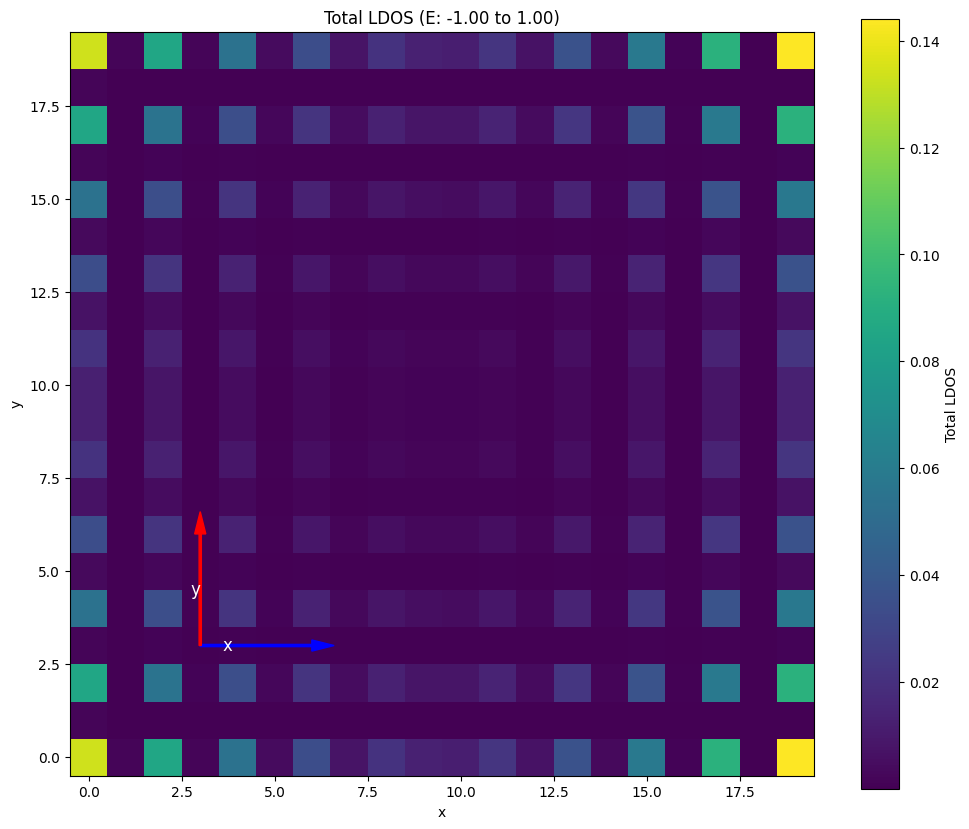

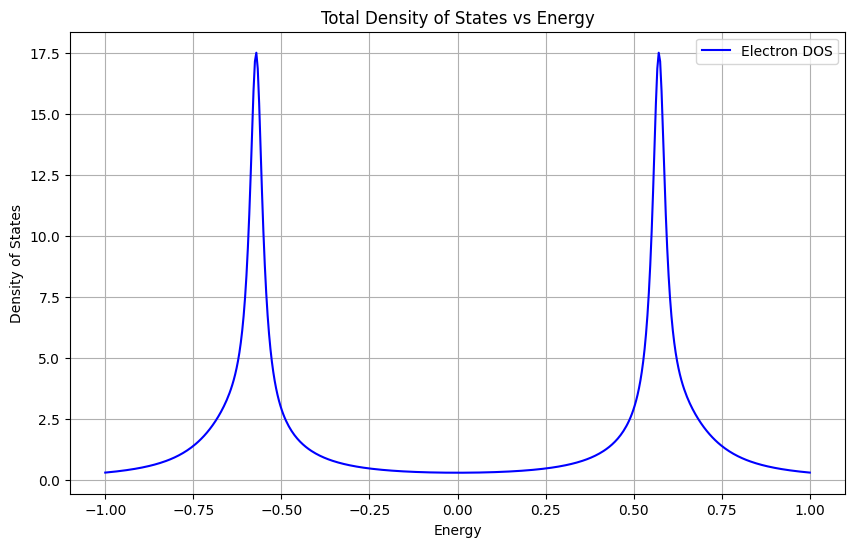

LDOS plots saved to data/ssh_2d/ssh2d_Nx10_Ny10_gx8.00+0.00j_gy8.00+0.00j_lx10.00+0.00j_ly10.00+0.00j_tlead1.00+0.00j_20250508_224240


In [43]:
plot_ldos_surface(
    E_values=E,
    rho_jj_values=ldos,
    E_lower=E_lower,
    E_upper=E_upper,
    Nx=Nx,
    Ny=Ny,
    plot_type='total',
    save_path=os.path.join(save_dir, "ldos_surface")
)

# Optionally, plot LDOS at specific energy values
# Change these values based on your system
energy_values_to_plot = [0.0]  # Example: plot at zero energy

for energy in energy_values_to_plot:
    plot_ldos_energy_slice(
        E_values=E,
        rho_jj_values=ldos,
        energy=energy,
        Nx=Nx,
        Ny=Ny,
        is_spin=False,  # Adjust based on your system
        save_path=os.path.join(save_dir, f"ldos_slice_E{energy:.3f}.png")
    )

# Calculate and plot total DOS (sum over all sites)
total_dos = ldos.sum(dim=1)  # Sum over all sites to get total DOS at each energy

plot_total_dos(
    E_values=E,
    rho_electron=total_dos,
    save_path=os.path.join(save_dir, "total_dos.png")
)

print(f"LDOS plots saved to {save_dir}")


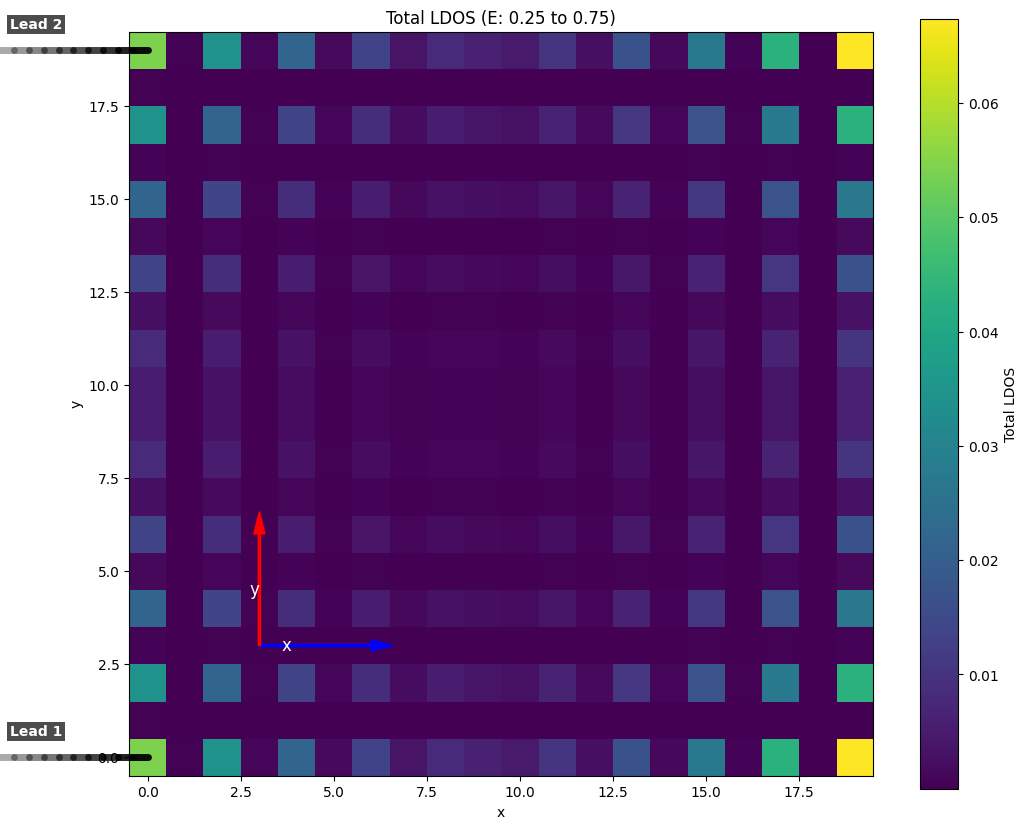

In [44]:

# Example of leads parameter
leads = [
    {
        "name": "Lead 1", 
        "position": position1,  # (x, y) coordinates of lead endpoint
        "direction": "left_to_right"  # Direction of lead extension
    },
    {
        "name": "Lead 2",
        "position": position2,
        "direction": "left_to_right"
    }
]

# Then pass this to the plotting functions
plot_ldos_surface(
    E_values=E,
    rho_jj_values=ldos,
    E_lower=0.25,
    E_upper=0.75,
    Nx=Nx,
    Ny=Ny,
    leads=leads,  # Add leads parameter
    save_path=os.path.join(save_dir, "ldos_with_leads")
)

In [45]:
# Import the functions from the new module
from dataplot.current_density_plot import (
    combine_current_densities,
    integrate_current_density,
    plot_integrated_current_density
)


combined_current_density = combine_current_densities(all_current_density)


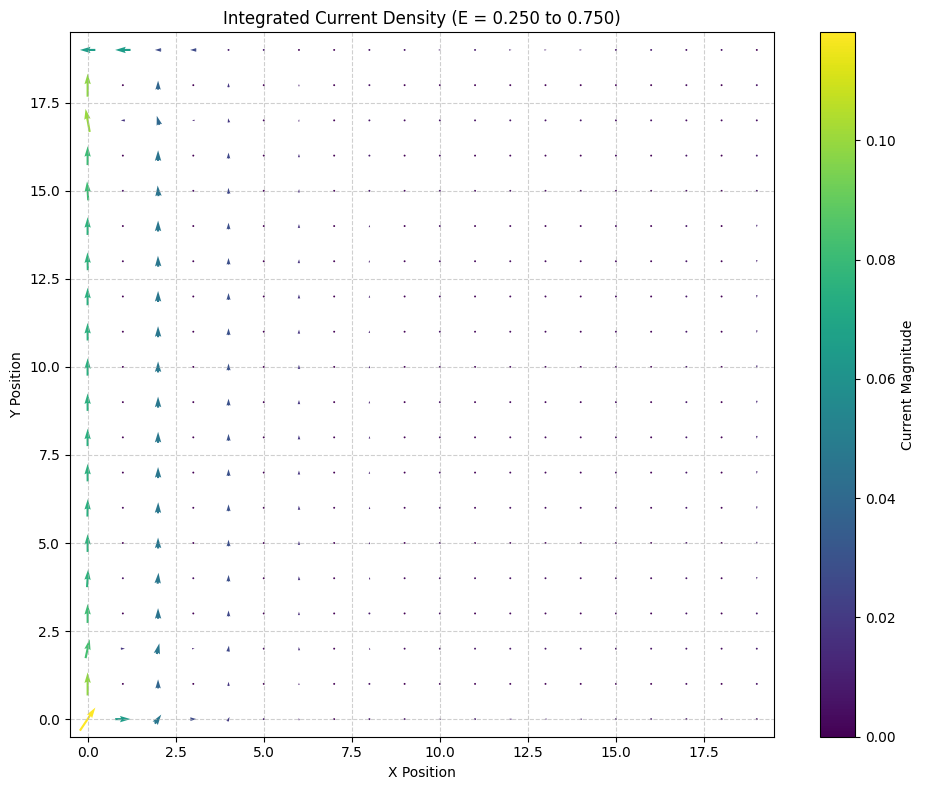

{'x': array([[ 6.56507611e-02, -1.70530460e-04,  1.76596865e-02,
         -1.96423774e-04,  5.00315242e-03, -1.73219349e-04,
          1.42071466e-03, -1.39294905e-04,  4.03440179e-04,
         -1.57356146e-04,  1.57241404e-04, -4.03640704e-04,
          1.39226802e-04, -1.42109115e-03,  1.73176362e-04,
         -5.00392076e-03,  1.96397625e-04, -1.76615193e-02,
          1.70517000e-04, -6.56560734e-02],
        [ 6.54802173e-02, -7.42413104e-05,  1.76111199e-02,
         -1.32032117e-04,  4.98613203e-03, -1.36145725e-04,
          1.41136604e-03, -1.17687239e-04,  3.94068455e-04,
         -1.44007048e-04,  1.43893485e-04, -3.94266273e-04,
          1.17620359e-04, -1.41174230e-03,  1.36105271e-04,
         -4.98690503e-03,  1.32010842e-04, -1.76129565e-02,
          7.42347111e-05, -6.54855296e-02],
        [ 2.69210041e-02, -1.20579178e-04,  1.09342085e-02,
         -2.11347229e-04,  3.73921869e-03, -2.07549485e-04,
          1.08928105e-03, -1.48841515e-04,  2.70742574e-04,
       

In [53]:

# Plot integrated current density for a specific energy window
plot_integrated_current_density(
    E_values=E,
    current_density=combined_current_density,
    E_lower=0.25,  # Lower energy bound
    E_upper=0.75,   # Upper energy bound
    grid_spacing=1,
    arrow_scale=3,
    cmap='viridis',
    save_path=os.path.join(save_dir, "integrated_current_density.png")
)

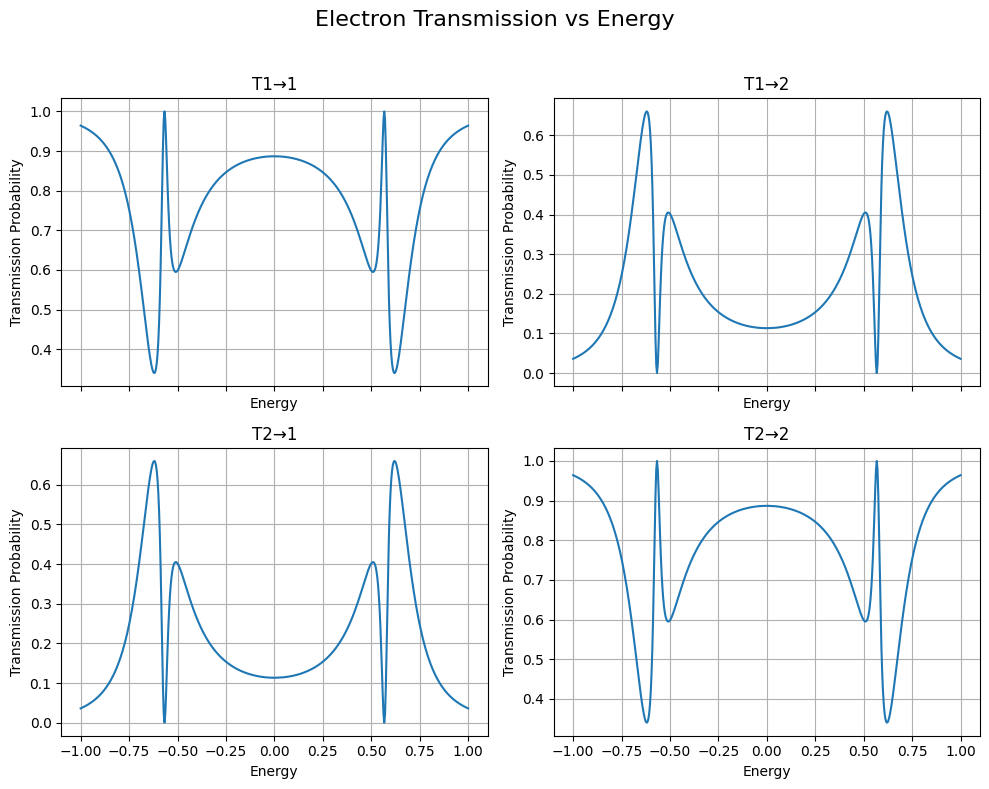

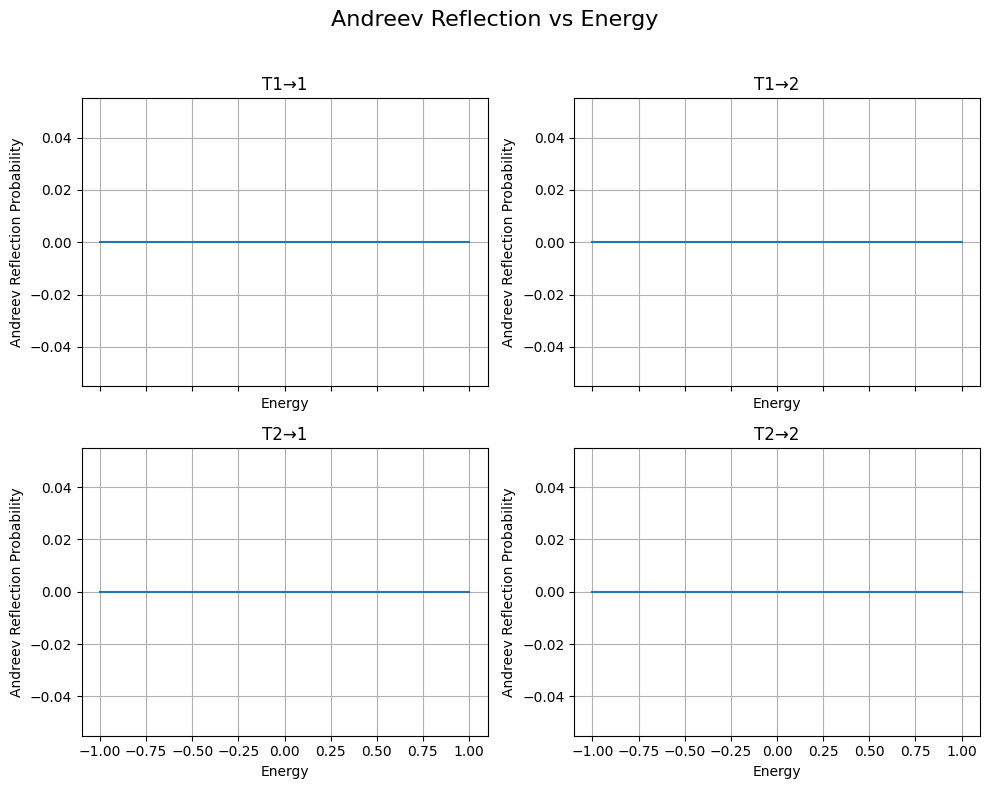

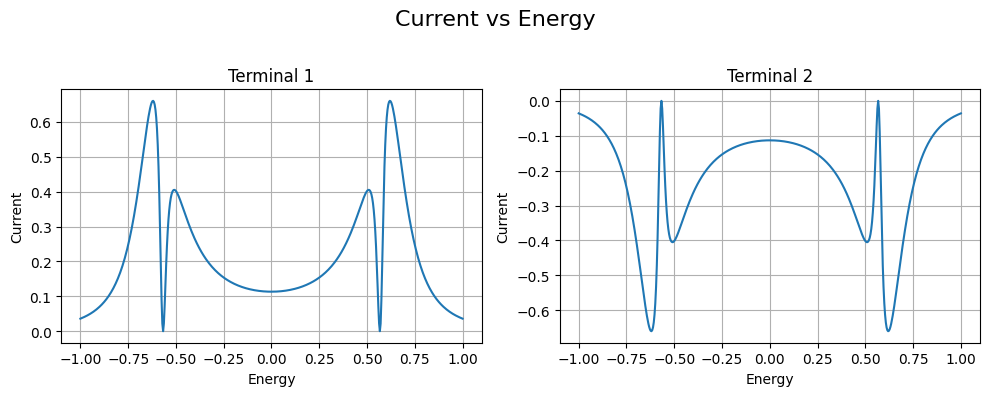

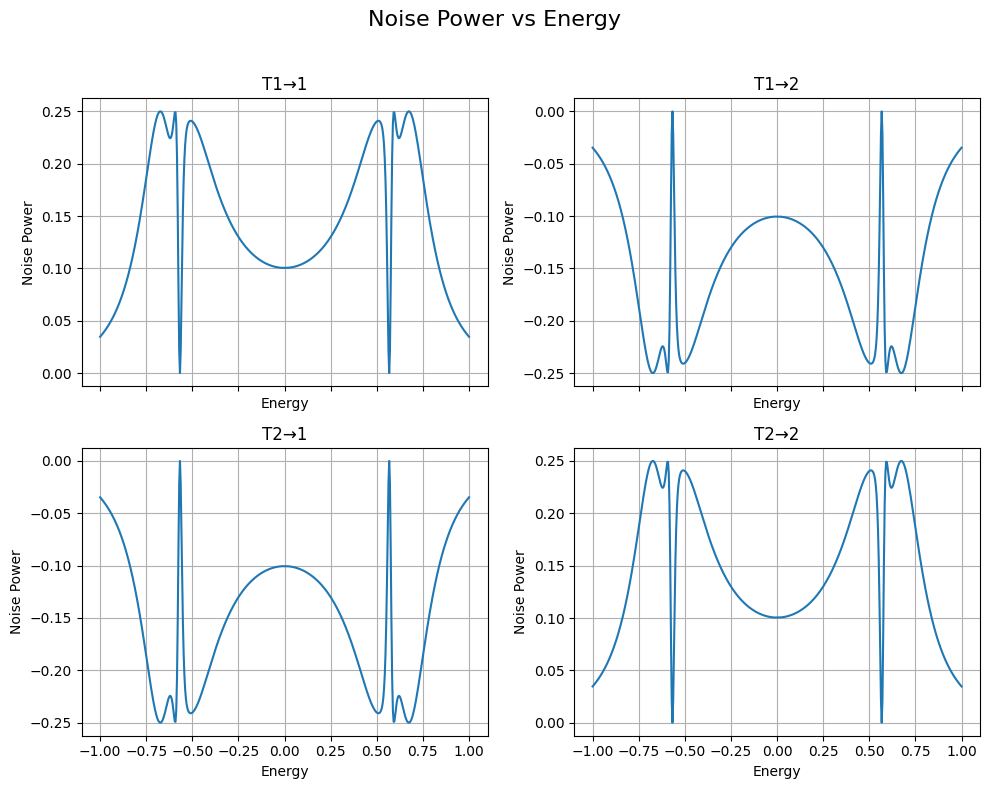

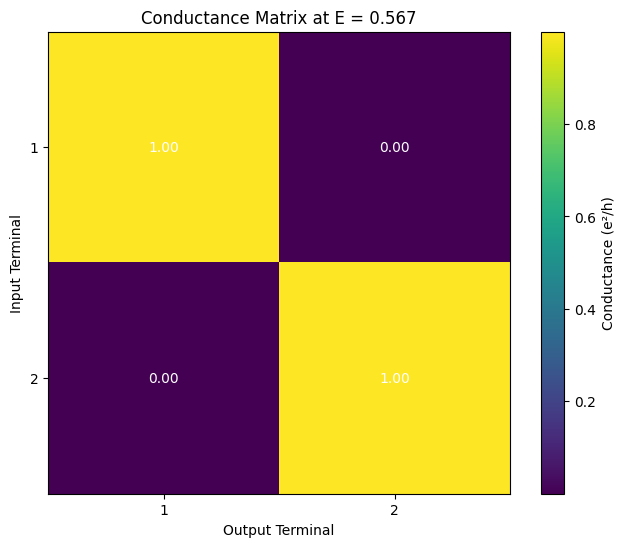

In [52]:
# After calculating results
from dataplot.transport_plot import plot_all_transport_quantities, plot_conductance_matrix

# Create transport data dictionary
transport_data = {
    'transmission': transmission,
    'andreev': andreev,
    'current': current,
    'noise': noise
}

# Plot all transport quantities
plot_all_transport_quantities(
    E_values=E,
    transport_data=transport_data,
    save_dir=f'{this_run_dir}/transport_plots'
)

# Plot conductance matrix at zero energy
plot_conductance_matrix(
    E_values=E,
    transport_data=transport_data,
    energy_point=0.567,
    save_path=f'{this_run_dir}/conductance_matrix_E0.png'
)

# Higher Order Corrlators

In [2]:
import os
os.chdir('/home/kt/calc/latticeG')

In [4]:
import os
import time
import torch
import numpy as np
import scipy.io as sio
from datetime import datetime
from hamiltonians.Central import SSH2DChainMethod
from hamiltonians.Lead import SpinlessLead
from genfunc_cf_deriv_method.calculations.calculation_cf_autograd import calculation_cf_autograd

# Set device for computation
funcDevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {funcDevice}")

# --- Define SSH 2D Model Parameters (same as above) ---
Nx_cell, Ny_cell = 10, 10  # Number of unit cells in x and y directions
Nx, Ny = Nx_cell * 2, Ny_cell * 2  # Total number of sites (2 sites per unit cell in each direction)
orb_size = 1  # Orbital size for 2D SSH model

# Define SSH parameters
gamma_x = torch.tensor(8, dtype=torch.complex64, device=funcDevice)  # Intra-cell hopping along x
gamma_y = torch.tensor(8, dtype=torch.complex64, device=funcDevice)  # Intra-cell hopping along y
lambda_x = torch.tensor(10.0, dtype=torch.complex64, device=funcDevice)  # Inter-cell hopping along x
lambda_y = torch.tensor(10.0, dtype=torch.complex64, device=funcDevice)  # Inter-cell hopping along y

# Create SSH 2D model
ssh2d_model = SSH2DChainMethod(
    Nx_cell=Nx_cell,
    Ny_cell=Ny_cell,
    gamma_x=gamma_x,
    gamma_y=gamma_y,
    lambda_x=lambda_x,
    lambda_y=lambda_y,
)

# Convert to BdG form for particle-hole calculations
H_2d_BdG = torch.kron(ssh2d_model.H_full, torch.tensor([[1, 0], [0, 0]], dtype=torch.complex64, device=funcDevice)) + \
           torch.kron(-ssh2d_model.H_full.conj(), torch.tensor([[0, 0], [0, 1]], dtype=torch.complex64, device=funcDevice))

# Verify Hamiltonian is Hermitian
hermitian_check = torch.allclose(H_2d_BdG, H_2d_BdG.conj().transpose(-1, -2), atol=1e-6)
print(f"Hamiltonian is Hermitian: {hermitian_check}")
print(f"Hamiltonian shape: {H_2d_BdG.shape}")

# Define parameters for the leads
mu_values = torch.tensor([-1.0, 1.0], dtype=torch.float32, device=funcDevice)
t_lead = torch.tensor(2.0, dtype=torch.float32, device=funcDevice)
temperature = torch.tensor(1e-6, dtype=torch.float32, device=funcDevice)

# Define energy range and calculation parameters
E_min, E_max = -1.0, 1.0
num_points = 200
eta = torch.tensor(1e-4, dtype=torch.float32, device=funcDevice)
chunk_size = 1

# Create energy grid
E = torch.linspace(E_min, E_max, steps=num_points, dtype=torch.float32, device=funcDevice)

# Create base directory to save results
base_results_dir = os.path.join("data", "ssh_2d", "higher_order_correlators", f"results_{datetime.now().strftime('%Y%m%d_%H%M')}")
os.makedirs(base_results_dir, exist_ok=True)

# Loop through different t_lead_central values
for t_lead_central_value in np.arange(0.1, 1.2, 0.3):
    t_lead_central = torch.tensor(t_lead_central_value, dtype=torch.float32, device=funcDevice)
    
    # Create directory with parameters in the name
    param_str = f"tlc{t_lead_central_value:.1f}_gx{gamma_x.item()}_gy{gamma_y.item()}_lx{lambda_x.item()}_ly{lambda_y.item()}"
    results_dir = os.path.join(base_results_dir, param_str)
    os.makedirs(results_dir, exist_ok=True)
    
    print(f"\n--- Processing t_lead_central = {t_lead_central_value:.1f} ---")
    
    # Create lead objects
    leads_info = []

    # Lead 1 at bottom-left corner (0,0)
    position1 = [(0, 0)]
    leads_info.append(
        SpinlessLead(
            mu=mu_values[0],
            t_lead_central=t_lead_central,
            temperature=temperature,
            connection_coordinates=position1,  # Connect to bottom-left corner
            central_Nx=Nx,
            central_Ny=Ny,
            t_lead=t_lead,
            device=funcDevice
        )
    )

    # Lead 2 at top-right corner (0, Ny-1)
    position2 = [(0, Ny-1)]
    leads_info.append(
        SpinlessLead(
            mu=mu_values[1],
            t_lead_central=t_lead_central,
            temperature=temperature,
            connection_coordinates=position2,  # Connect to top-right corner
            central_Nx=Nx,
            central_Ny=Ny,
            t_lead=t_lead,
            device=funcDevice
        )
    )

    # Print lead connection information
    for i, lead in enumerate(leads_info):
        print(f"Lead {i} connection coordinates: {lead.connection_coordinates}, μ={mu_values[i]}")

    # Process energy values in chunks
    results_list = []

    start_time = time.time()
    for start in range(0, E.size(0), chunk_size):
        end = min(start + chunk_size, E.size(0))
        chunked_E = E[start:end]
        print(f"Processing chunk {start} to {end}")
        
        # Call the calculation function for the current chunk
        results = calculation_cf_autograd(H_2d_BdG, chunked_E, eta, leads_info, max_derivative_order=4)
        results_list.append(results)
    calc_time = time.time() - start_time

    # Combine results from all chunks
    combined_results = {
        'gen_func_values_real': torch.cat([res['gen_func_values_real'] for res in results_list], dim=0),
        'gen_func_values_imag': torch.cat([res['gen_func_values_imag'] for res in results_list], dim=0),
        'derivatives': {}
    }

    # Combine derivatives
    for order in results_list[0]['derivatives'].keys():
        combined_results['derivatives'][order] = torch.cat([res['derivatives'][order] for res in results_list], dim=0)

    # Create filename with parameters
    filename = f"ssh2d_Nx{Nx}_Ny{Ny}_gx{gamma_x.item():.2f}_gy{gamma_y.item():.2f}_lx{lambda_x.item():.2f}_ly{lambda_y.item():.2f}_tlc{t_lead_central_value:.2f}_higher_order_correlators.mat"
    filepath = os.path.join(results_dir, filename)

    # Save results with all parameters
    save_dict = {
        'gen_func_values_real': combined_results['gen_func_values_real'].cpu().numpy(),
        'gen_func_values_imag': combined_results['gen_func_values_imag'].cpu().numpy(),
        'derivatives': {k: v.cpu().numpy() for k, v in combined_results['derivatives'].items()},
        'E': E.cpu().numpy(),
        'Nx_cell': Nx_cell,
        'Ny_cell': Ny_cell,
        'gamma_x': gamma_x.item(),
        'gamma_y': gamma_y.item(),
        'lambda_x': lambda_x.item(),
        'lambda_y': lambda_y.item(),
        'mu_values': mu_values.cpu().numpy(),
        't_lead_central': t_lead_central.item(),
        't_lead': t_lead.item(),
        'temperature': temperature.item(),
        'calculation_time': calc_time
    }
    sio.savemat(filepath, save_dict)
    print(f"Results saved to {filepath}")
    print(f"Calculation time: {calc_time:.2f} seconds")

print("Higher order correlator calculations completed for all t_lead_central values.")

Using device: cpu
Hamiltonian is Hermitian: True
Hamiltonian shape: torch.Size([800, 800])

--- Processing t_lead_central = 0.1 ---
Lead 0 connection coordinates: [(0, 0)], μ=-1.0
Lead 1 connection coordinates: [(0, 19)], μ=1.0
Processing chunk 0 to 1
Processing chunk 1 to 2
Processing chunk 2 to 3
Processing chunk 3 to 4
Processing chunk 4 to 5
Processing chunk 5 to 6
Processing chunk 6 to 7
Processing chunk 7 to 8
Processing chunk 8 to 9
Processing chunk 9 to 10
Processing chunk 10 to 11
Processing chunk 11 to 12
Processing chunk 12 to 13
Processing chunk 13 to 14
Processing chunk 14 to 15
Processing chunk 15 to 16
Processing chunk 16 to 17
Processing chunk 17 to 18
Processing chunk 18 to 19
Processing chunk 19 to 20
Processing chunk 20 to 21
Processing chunk 21 to 22
Processing chunk 22 to 23
Processing chunk 23 to 24
Processing chunk 24 to 25
Processing chunk 25 to 26
Processing chunk 26 to 27
Processing chunk 27 to 28
Processing chunk 28 to 29
Processing chunk 29 to 30
Processing 